# Benchmark

```python
X = sorted(np.random.uniform(0, 10, 50_000))
y = [[math.cos(x)] for x in X]

layers = [
    Linear(1,100, activation=Sigmoid()),
    Linear(100,100, activation=Sigmoid()),
    Linear(100,100, activation=Sigmoid()),
    Linear(100,100, activation=Sigmoid()),
    Linear(100,100, activation=Sigmoid()),
    Linear(100,1),
]
```

num_cpu 1 - 4.129835605621338 sec

num_cpu 3 - 4.494138956069946 sec

---

```python
X = sorted(np.random.uniform(0, 10, 3_000_000))
y = [[math.cos(x)] for x in X]

layers = [
    Linear(1,100, activation=Sigmoid()),
    Linear(100,1),
]
```

without GPU - 29.550464153289795 (8 sec Update weights and biases step)

with GPU - 25.81462264060974 (4 sec Update weights and biases step)

In [1]:
from typing import Union, TypeAlias
import math
import time
import datetime
import json
import ctypes
import multiprocessing

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import nn

import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce MX150'

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [ ]:
!clang -shared -o main.so -fPIC -O3 -fopenmp -ffast-math -march=native -framework OpenCL main.c src/functions.c src/activations.c src/loss.c src/init.c src/json.c src/adam.c src/forward.c src/backward.c src/logger.c src/predict.c

In [6]:
lib = ctypes.CDLL('./main.so')


NUM_CPU = multiprocessing.cpu_count()

In [7]:
Sample: TypeAlias = list[float]
Samples: TypeAlias = list[Sample]

Target: TypeAlias = Union[int, float]
Targets: TypeAlias = list[Target]

Weights: TypeAlias = list[list[float]]

In [8]:
# Activation functions

def ReLU():
    return 0

def Sigmoid():
    return 1

def Softmax():
    return 2

def Empty():
    return 3

In [9]:
# Loss functions

def MSELoss():
    return 0

def CrossEntropy():
    return 1

In [10]:
class Dataset:
    def __init__(self, samples: Samples, targets: Targets) -> None:
        self.samples: Samples = np.array(samples)
        self._len = len(samples)
        self.targets: Targets = np.array(targets)

    def __len__(self) -> int:
        return self._len

    def __getitem__(self, index) -> Sample:
        return self.samples[index], self.targets[index]

    def __iter__(self):
        return iter(zip(self.samples, self.targets))

In [11]:
class Linear:
    def __init__(self, n_inputs: int, n_neurons: int, activation = None, dropout: float = 1.0) -> None:
        self.n_inputs = n_inputs
        self.n_neurons = n_neurons

        self.weights = []
        self.bias = []
        self.output = []

        if activation is None:
            self.activation = Empty()
        else:
            self.activation = activation
        
        self.dropout = dropout


class Conv2d:
    def __init__(self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        stride: int = 1,
        padding: int = 0,
        activation: int = None,
        batch_norm: int = None,
) -> None:
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.batch_norm = batch_norm
        self.conv_layer = nn.Sequential()

        conv2d = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        conv2d = conv2d.to(device)
        self.conv_layer.append(conv2d)

        if batch_norm:
            batchnorm2d = nn.BatchNorm2d(batch_norm)
            batchnorm2d = batchnorm2d.to(device)
            self.conv_layer.append(batchnorm2d)

        if activation is None:
            self.activation = Empty()
        else:
            self.activation = activation
            if activation == 0:
                self.conv_layer.append(nn.ReLU())
            elif activation == 1:
                self.conv_layer.append(nn.Sigmoid())
            elif activation == 2:
                self.conv_layer.append(nn.Softmax())

    def forward(self, matrix: torch.Tensor) -> torch.Tensor:
        return self.conv_layer(matrix)


class MaxPool2d:
    def __init__(self, kernel_size: int, stride: int) -> None:
        self.kernel_size = kernel_size
        self.stride = stride

        self.layer = nn.MaxPool2d(kernel_size=kernel_size, stride=stride)

    def forward(self, matrix: torch.Tensor) -> torch.Tensor:
        return self.layer(matrix)


LinearLayers: TypeAlias = list[Linear]
Conv2dLayers: TypeAlias = list[Conv2d | MaxPool2d]
Layers: TypeAlias = list[Linear | Conv2d | MaxPool2d]

In [12]:
MODEL_VERSION = "2.0"


class Model:
    def __init__(self, layers: Layers, loss: int, regression: bool = True, max_change: float = 0.1, random_state: int = -1) -> None:
        self.linear_layers: LinearLayers = []
        self.conv2d_layers: Conv2dLayers = []

        for layer in layers:
            if layer.__class__.__name__ == "Linear":
                self.linear_layers.append(layer)
            elif layer.__class__.__name__ == "Conv2d" or layer.__class__.__name__ == "MaxPool2d":
                self.conv2d_layers.append(layer)

        self.layers = self.conv2d_layers + self.linear_layers
        self._layers_len = len(self.linear_layers) + len(self.conv2d_layers)
        self.loss = loss
        self.regression = regression
        self.max_change = max_change
        self.random_state = random_state

    def fit(
        self,
        dataset: Dataset,
        n_epoch: int = 1,
        learning_rate: float = 0.01,
        verbose: bool = True,
        num_cpu: int = 1,
        gpu: bool = False,
    ):
        if verbose:
            self.logger_info("Preparing the dataset.")

        array_samples = []
        array_targets = []
        for sample, target in dataset:
            array_samples.append(sample)
            array_targets.append(target)
        array_targets = np.array(array_targets, dtype=np.float32)

        linear_layer_sizes = []
        activations = []
        for layer in self.linear_layers:
            linear_layer_sizes.append([float(layer.n_inputs), float(layer.n_neurons)])
            activations.append(layer.activation)

        linear_layer_sizes = np.array(linear_layer_sizes, dtype=np.float32)
        activations = np.array(activations, dtype=np.float32)
        dropouts = np.array([layer.dropout for layer in self.linear_layers], dtype=np.float32)
        losses = np.zeros(n_epoch, dtype=np.float32)

        layers = []
        if self.conv2d_layers:
            layers.append("Conv2d")
        if self.linear_layers:
            layers.append("Linear")
        layers = [s.encode('utf-8') for s in layers]
        layers_type = ctypes.c_char_p * len(layers)
        layers = layers_type(*layers)

        if verbose:
            self.logger_info("Dataset preparation completed.")

        if verbose:
            self.logger_info("Training has started.")

        # Apply Conv2d to samples
        if self.conv2d_layers:
            if verbose:
                self.logger_info("Apply Conv2d.")

            array_samples_after_conv2d = []
            for sample in array_samples:
                sample = torch.tensor(sample, dtype=torch.float32)
                sample = sample.to(device)
                sample = self.process_sample_conv2d(sample=sample)
                array_samples_after_conv2d.append(sample)
            array_samples = array_samples_after_conv2d
        array_samples = np.array(array_samples, dtype=np.float32)

        lib.fit.argtypes = [
            ctypes.POINTER(ctypes.c_float),
            ctypes.POINTER(ctypes.c_float),
            ctypes.c_int,
            ctypes.c_int,
            ctypes.c_int,
            ctypes.c_int,
            ctypes.c_int,
            ctypes.POINTER(ctypes.c_float),
            ctypes.c_int,
            ctypes.c_int,
            ctypes.POINTER(ctypes.c_float),
            ctypes.c_int,
            ctypes.c_int,
            ctypes.c_int,
            ctypes.c_float,
            ctypes.c_int,
            ctypes.c_float,
            ctypes.c_int,
            ctypes.c_int,
            ctypes.c_int,
            ctypes.POINTER(ctypes.c_float),
            ctypes.POINTER(ctypes.c_float),
            ctypes.c_int,
            layers_type,
            ctypes.c_int,
        ]

        lib.fit.restype = None

        lib.fit(
            array_samples.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
            array_targets.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
            len(array_samples),
            len(array_samples[0]),
            len(array_samples[0][0]),
            len(array_targets),
            len(array_targets[0]),
            linear_layer_sizes.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
            len(linear_layer_sizes),
            len(linear_layer_sizes[0]),
            activations.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
            len(activations),
            self.loss,
            n_epoch,
            learning_rate,
            verbose,
            self.max_change,
            self.random_state,
            self.regression,
            num_cpu,
            dropouts.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
            losses.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
            gpu,
            layers,
            len(layers)
        )

        if verbose:
            self.logger_info("Training is over.")

        with open("weights.json", 'r') as file:
            weights = json.load(file)

        with open("biases.json", 'r') as file:
            biases = json.load(file)

        for i in range(len(self.linear_layers)):
            self.linear_layers[i].weights = weights[i]
            self.linear_layers[i].bias = biases[i]
        
        return losses

    def predict_one(self, sample: Sample, predict_proba: bool = False, gpu: bool = False) -> float:
        # Apply Conv2d to samples
        if self.conv2d_layers:
            sample = torch.tensor(sample, dtype=torch.float32)
            sample = sample.to(device)
            sample = self.process_sample_conv2d(sample=sample)
        sample = np.array(sample, dtype=np.float32)

        weights = [layer.weights for layer in self.linear_layers]
        weights = self.flatten_3d_array(weights)
        weights = np.array(weights, dtype=np.float32)

        biases = [layer.bias for layer in self.linear_layers]
        biases = self.flatten_3d_array(biases)
        biases = np.array(biases, dtype=np.float32)

        linear_layer_sizes = []
        activations = []
        for layer in self.linear_layers:
            linear_layer_sizes.append([float(layer.n_inputs), float(layer.n_neurons)])
            activations.append(layer.activation)

        linear_layer_sizes = np.array(linear_layer_sizes, dtype=np.float32)
        activations = np.array(activations, dtype=np.float32)
        prediction = np.zeros(self.layers[self._layers_len - 1].n_neurons, dtype=np.float32)

        layers = []
        if self.conv2d_layers:
            layers.append("Conv2d")
        if self.linear_layers:
            layers.append("Linear")
        layers = [s.encode('utf-8') for s in layers]
        layers_type = ctypes.c_char_p * len(layers)
        layers = layers_type(*layers)

        lib.predict_one.argtypes = [
            ctypes.POINTER(ctypes.c_float),
            ctypes.c_int,
            ctypes.c_int,
            ctypes.POINTER(ctypes.c_float),
            ctypes.POINTER(ctypes.c_float),
            ctypes.POINTER(ctypes.c_float),
            ctypes.c_int,
            ctypes.c_int,
            ctypes.POINTER(ctypes.c_float),
            ctypes.c_int,
            ctypes.POINTER(ctypes.c_float),
            ctypes.c_int,
            layers_type,
            ctypes.c_int,
        ]

        lib.predict_one.restype = None

        lib.predict_one(
            sample.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
            len(sample),
            len(sample[0]),
            weights.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
            biases.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
            linear_layer_sizes.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
            len(linear_layer_sizes),
            len(linear_layer_sizes[0]),
            activations.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
            len(activations),
            prediction.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
            gpu,
            layers,
            len(layers),
        )

        if predict_proba:
            return prediction
        if self.regression:
            return np.mean(prediction)
        return np.argmax(prediction)

    def predict(self, samples: Samples, predict_proba: bool = False, num_cpu: int = 1, gpu: bool = False) -> float:
        # Apply Conv2d to samples
        if self.conv2d_layers:
            array_samples_after_conv2d = []
            for sample in samples:
                sample = torch.tensor(sample, dtype=torch.float32)
                sample = sample.to(device)
                sample = self.process_sample_conv2d(sample=sample)
                array_samples_after_conv2d.append(sample)
            samples = array_samples_after_conv2d
        samples = np.array(samples, dtype=np.float32)

        weights = [layer.weights for layer in self.linear_layers]
        weights = self.flatten_3d_array(weights)
        weights = np.array(weights, dtype=np.float32)

        biases = [layer.bias for layer in self.linear_layers]
        biases = self.flatten_3d_array(biases)
        biases = np.array(biases, dtype=np.float32)

        linear_layer_sizes = []
        activations = []
        for layer in self.linear_layers:
            linear_layer_sizes.append([float(layer.n_inputs), float(layer.n_neurons)])
            activations.append(layer.activation)

        linear_layer_sizes = np.array(linear_layer_sizes, dtype=np.float32)
        activations = np.array(activations, dtype=np.float32)

        samples_len = len(samples)
        n_neurons_last = self.layers[self._layers_len - 1].n_neurons
        predictions = np.zeros(samples_len * n_neurons_last, dtype=np.float32)

        layers = []
        if self.conv2d_layers:
            layers.append("Conv2d")
        if self.linear_layers:
            layers.append("Linear")
        layers = [s.encode('utf-8') for s in layers]
        layers_type = ctypes.c_char_p * len(layers)
        layers = layers_type(*layers)

        lib.predict.argtypes = [
            ctypes.POINTER(ctypes.c_float),
            ctypes.c_int,
            ctypes.c_int,
            ctypes.c_int,
            ctypes.POINTER(ctypes.c_float),
            ctypes.POINTER(ctypes.c_float),
            ctypes.POINTER(ctypes.c_float),
            ctypes.c_int,
            ctypes.c_int,
            ctypes.POINTER(ctypes.c_float),
            ctypes.c_int,
            ctypes.POINTER(ctypes.c_float),
            ctypes.c_int,
            ctypes.c_int,
            layers_type,
            ctypes.c_int,
        ]

        lib.predict.restype = None

        lib.predict(
            samples.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
            len(samples),
            len(samples[0]),
            len(samples[0][0]),
            weights.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
            biases.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
            linear_layer_sizes.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
            len(linear_layer_sizes),
            len(linear_layer_sizes[0]),
            activations.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
            len(activations),
            predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
            num_cpu,
            gpu,
            layers,
            len(layers),
        )

        predictions_2d = []
        for i in range(samples_len):
            sample = []
            for j in range(n_neurons_last):
                index = i * n_neurons_last + j
                sample.append(predictions[index])
            predictions_2d.append(sample)

        if predict_proba:
            return predictions_2d
        if self.regression:
            result = np.array([np.mean(sample) for sample in predictions_2d])
            return result

        result = np.array([np.argmax(sample) for sample in predictions_2d])
        return result

    def flatten_3d_array(self, arr) -> list[float]:
        flat_list = []
        for row in arr:
            for subarr in row:
                flat_list.extend(subarr)
        return flat_list

    def process_sample_conv2d(self, sample: torch.Tensor):
        for layer in self.conv2d_layers:
            sample = layer.forward(matrix=sample)
        return [sample.cpu().flatten().detach().clone().numpy()]

    def set_weights(self, weights: Weights) -> None:
        for w, layer in zip(weights, self.linear_layers):
            layer.weights = w

    def get_time(self) -> str:
        return datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S")
    
    def logger_info(self, s: str) -> None:
        t = self.get_time()
        print(f"[{t}] - INFO - {s}")

    @property
    def weights(self) -> Weights:
        weights = [layer.weights for layer in self.linear_layers]
        return weights

    def _get_activation_name(self, n):
        if n == 0:
            return "ReLU()"
        elif n == 1:
            return "Sigmoid()"
        elif n == 2:
            return "Softmax()"
        elif n == 3:
            return "Empty()"

    def _get_loss_name(self, n):
        if n == 0:
            return "MSELoss()"
        elif n == 1:
            return "CrossEntropy()"

    def __str__(self):
        s = f"Phils Model v{MODEL_VERSION}\n\n"

        loss = f"- Loss = {self._get_loss_name(self.loss)}\n"
        regression = f"- Regression = {self.regression}\n"

        s += loss
        s += regression

        s += "- Layers:\n"

        for i in range(self._layers_len):
            layer = self.layers[i]
            layer_name: str = layer.__class__.__name__

            if layer_name == "Linear":
                activation = self._get_activation_name(layer.activation)
                layer_str = f"\t{layer_name}(n_inputs={layer.n_inputs}, n_neurons={layer.n_neurons}, activation={activation}, dropout={layer.dropout})\n"
            elif layer_name == "Conv2d":
                activation = self._get_activation_name(layer.activation)
                layer_str = f"\t{layer_name}(in_channels={layer.in_channels}, out_channels={layer.out_channels}, kernel_size={layer.kernel_size}, stride={layer.stride}, padding={layer.padding}, activation={activation}, batch_norm={layer.batch_norm})\n"
            elif layer_name == "MaxPool2d":
                layer_str = f"\t{layer_name}(kernel_size={layer.kernel_size}, stride={layer.stride})\n"

            s += layer_str
        return s

In [13]:
layers = [
    Conv2d(1, 128, kernel_size=3, stride=1, padding=1, activation=Sigmoid(), batch_norm=128),
    MaxPool2d(kernel_size=2, stride=2),
    Conv2d(128, 256, kernel_size=3, stride=1, padding=1, activation=Sigmoid(), batch_norm=256),
    MaxPool2d(kernel_size=2, stride=2),
    Conv2d(256, 128, kernel_size=3, stride=1, padding=1, activation=Sigmoid(), batch_norm=128),
    MaxPool2d(kernel_size=2, stride=2),
    Linear(1152,128, activation=Sigmoid()),
    Linear(128,10, activation=Softmax()),
]


model = Model(layers=layers, loss=CrossEntropy(), regression=False, max_change=0.00001)

print(model)

Phils Model v2.0

- Loss = CrossEntropy()
- Regression = False
- Layers:
	Conv2d(in_channels=1, out_channels=128, kernel_size=3, stride=1, padding=1, activation=Sigmoid(), batch_norm=128)
	MaxPool2d(kernel_size=2, stride=2)
	Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, activation=Sigmoid(), batch_norm=256)
	MaxPool2d(kernel_size=2, stride=2)
	Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1, activation=Sigmoid(), batch_norm=128)
	MaxPool2d(kernel_size=2, stride=2)
	Linear(n_inputs=1152, n_neurons=128, activation=Sigmoid(), dropout=1.0)
	Linear(n_inputs=128, n_neurons=10, activation=Softmax(), dropout=1.0)



## Dataset

In [59]:
X = sorted(np.random.uniform(0, 10, 10_000))
y = [[math.cos(x)] for x in X]

X_nested = list(X)
for i in range(len(X)):
    X_nested[i] = [[X[i]]]

X_nested = np.array(X_nested)

X_train, X_val, y_train, y_val = train_test_split(X_nested, y, train_size=0.8)

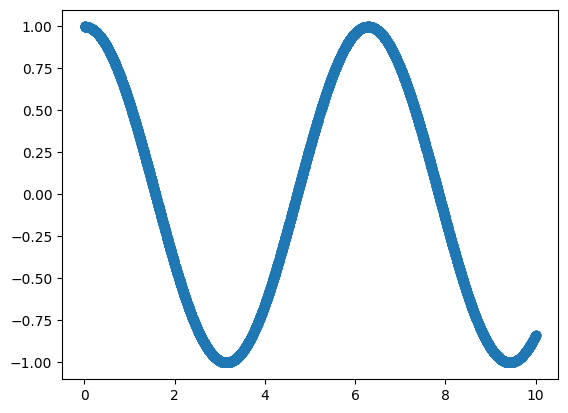

In [47]:
plt.plot(X, y, 'o')
plt.show()

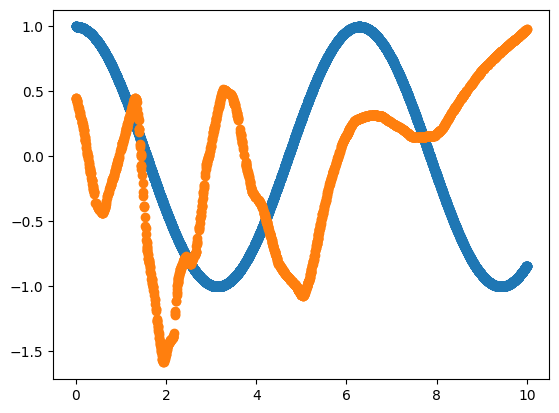

In [ ]:
lib = ctypes.CDLL('./main.so')

train_dataset = Dataset(samples=X_train, targets=y_train)

layers = [
    Linear(1,100, activation=Sigmoid(), dropout=0.2),
    Linear(100,100, activation=Sigmoid(), dropout=0.2),
    Linear(100,1),
]

model = Model(layers=layers, loss=MSELoss(), regression=True, max_change=0.0001)
losses = model.fit(dataset=train_dataset, n_epoch=1, learning_rate=0.1, verbose=True, num_cpu=NUM_CPU)

predictions = model.predict(X_val, num_cpu=NUM_CPU)

plt.plot(X_train.reshape(-1, 1), y_train, 'o')
plt.plot(X_val.reshape(-1, 1), predictions, 'o')
plt.show()

# LinearRegression

In [14]:
from sklearn.linear_model import LinearRegression

In [15]:
sklearn_X_train = np.array(X_train)
sklearn_X_train = sklearn_X_train.reshape(-1, 1)

sklearn_y_val = np.array(y_val)
sklearn_y_val = sklearn_y_val.reshape(-1, 1)

In [16]:
sklearn_model = LinearRegression().fit(sklearn_X_train, y_train)

In [17]:
sklearn_preds = sklearn_model.predict(sklearn_y_val)

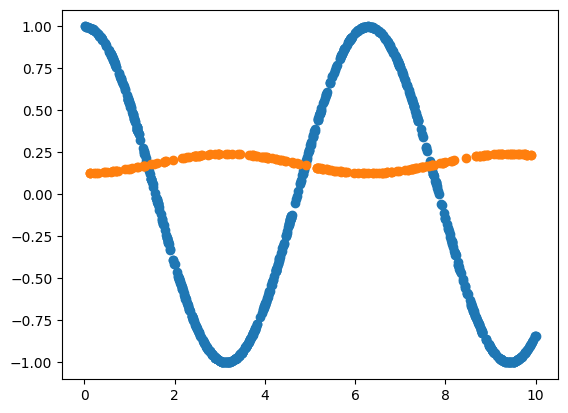

In [18]:
plt.plot(sklearn_X_train, y_train, 'o')
plt.plot(X_val, sklearn_preds, 'o')
plt.show()

# MLPRegressor

In [19]:
from sklearn.neural_network import MLPRegressor

In [20]:
sklearn_model = MLPRegressor(random_state=0).fit(sklearn_X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1770: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [21]:
sklearn_preds = sklearn_model.predict(sklearn_y_val)

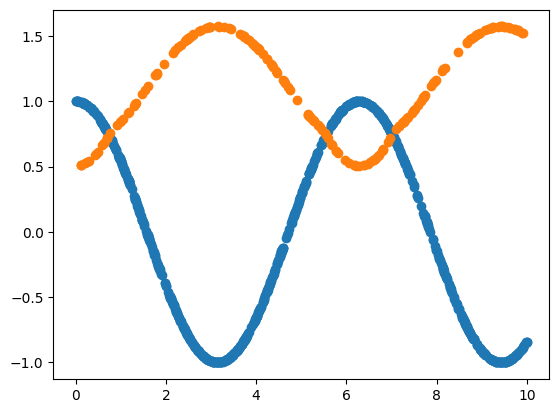

In [22]:
plt.plot(sklearn_X_train, y_train, 'o')
plt.plot(X_val, sklearn_preds, 'o')
plt.show()

# Make Moons dataset

In [176]:
from sklearn.datasets import make_moons

In [60]:
X, y = make_moons(n_samples=5000, noise=0.2)

X_nested = list(X)
for i in range(len(X)):
    X_nested[i] = [X[i]]

y = list(y)
for i in range(len(y)):
    if y[i] == 0:
        y[i] = np.array([1, 0])
    elif y[i] == 1:
        y[i] = np.array([0, 1])

y = np.array(y)

X_nested = np.array(X_nested)

In [61]:
X_train, X_val, y_train, y_val = train_test_split(X_nested, y, train_size=0.8)

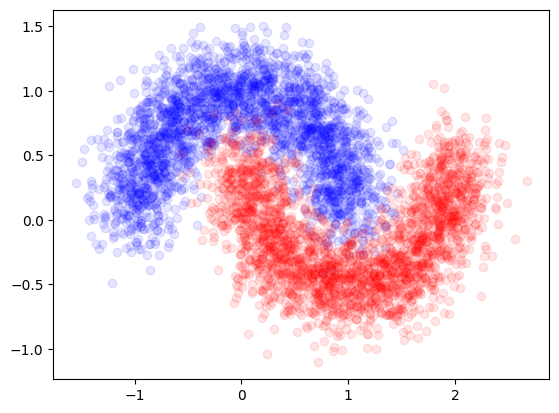

In [181]:
class_1_X = []
class_2_X = []

class_1_y = []
class_2_y = []

class_1_color = "blue"
class_2_color = "red"

for i in range(len(y)):
    if list(y[i]) == [1, 0]:
        class_1_X.append(X[i][0])
        class_1_y.append(X[i][1])
    elif list(y[i]) == [0, 1]:
        class_2_X.append(X[i][0])
        class_2_y.append(X[i][1])


plt.plot(class_1_X, class_1_y, 'o', color=class_1_color, alpha=0.1)
plt.plot(class_2_X, class_2_y, 'o', color=class_2_color, alpha=0.1)
plt.show()

In [ ]:
lib = ctypes.CDLL('./main.so')

train_dataset = Dataset(samples=X_train, targets=y_train)

layers = [
    Linear(2,100, activation=Sigmoid(), dropout=1.0),
    Linear(100,2, activation=Softmax()),
]


model = Model(layers=layers, loss=CrossEntropy(), regression=False, max_change=0.000001)
losses = model.fit(dataset=train_dataset, n_epoch=1, learning_rate=0.1, verbose=True, num_cpu=NUM_CPU)

Preparing the dataset.
Dataset preparation completed.
Training has started.
Epoch 1 / 1. Loss: -0.649200
Training is over.


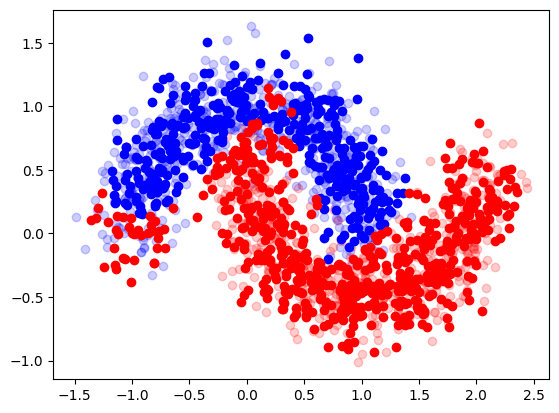

In [62]:
class_1_X_test = []
class_2_X_test = []

class_1_y_test = []
class_2_y_test = []


predictions = model.predict(X_val)

for i in range(len(X_val)):
    prediction = predictions[i]
    sample = X_val[i]
    if prediction == 0:
        class_1_X_test.append(sample[0][0])
        class_1_y_test.append(sample[0][1])
    elif prediction == 1:
        class_2_X_test.append(sample[0][0])
        class_2_y_test.append(sample[0][1])

plt.plot(class_1_X, class_1_y, 'o', color=class_1_color, alpha=0.2)
plt.plot(class_2_X, class_2_y, 'o', color=class_2_color, alpha=0.2)
plt.plot(class_1_X_test, class_1_y_test, 'o', color=class_1_color, alpha=1)
plt.plot(class_2_X_test, class_2_y_test, 'o', color=class_2_color, alpha=1)
plt.show()

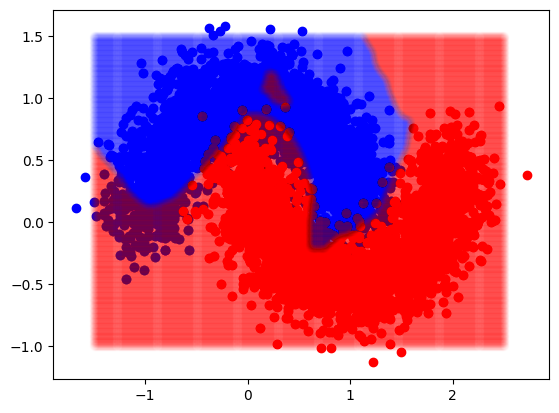

In [63]:
class_1_X = []
class_2_X = []

class_1_y = []
class_2_y = []

class_1_color = "blue"
class_2_color = "red"

for i in range(len(y)):
    if list(y[i]) == [1, 0]:
        class_1_X.append(X[i][0])
        class_1_y.append(X[i][1])
    elif list(y[i]) == [0, 1]:
        class_2_X.append(X[i][0])
        class_2_y.append(X[i][1])

class_1_X_test = []
class_2_X_test = []

class_1_y_test = []
class_2_y_test = []

x_min, x_max = -1.5, 2.5
y_min, y_max = -1, 1.5
step = 0.01

# Создаем равномерную сетку узлов (X,Y)
xx, yy = np.meshgrid(np.arange(x_min, x_max + step, step),
                     np.arange(y_min, y_max + step, step))

points = np.c_[xx.ravel(), yy.ravel()]


points_nested = []
for i in range(len(points)):
    sample = [points[i]]
    points_nested.append(sample)

predictions = model.predict(points_nested, num_cpu=NUM_CPU)

for i in range(len(points_nested)):
    sample = points_nested[i]
    prediction = predictions[i]

    if prediction == 0:
        class_1_X_test.append(sample[0][0])
        class_1_y_test.append(sample[0][1])
    elif prediction == 1:
        class_2_X_test.append(sample[0][0])
        class_2_y_test.append(sample[0][1])

plt.plot(class_1_X, class_1_y, 'o', color=class_1_color, alpha=1)
plt.plot(class_2_X, class_2_y, 'o', color=class_2_color, alpha=1)
plt.plot(class_1_X_test, class_1_y_test, 'o', color=class_1_color, alpha=0.01)
plt.plot(class_2_X_test, class_2_y_test, 'o', color=class_2_color, alpha=0.01)
plt.show()

# Sklearn MNIST dataset

In [10]:
from sklearn.datasets import load_digits

In [11]:
dataset = load_digits(n_class=2)

In [12]:
X, y = dataset.data, dataset.target

# for i in range(len(X)):
#     X[i] /= 255

X_reshaped = []
for i in range(len(X)):
    x = [X[i]]
    X_reshaped.append(x)

y_one_hot = np.zeros(len(y))
y_one_hot = list(y_one_hot)
for i in range(len(y)):
    if y[i] == 0:
        y_one_hot[i] = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    elif y[i] == 1:
        y_one_hot[i] = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
    elif y[i] == 2:
        y_one_hot[i] = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
    elif y[i] == 3:
        y_one_hot[i] = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
    elif y[i] == 4:
        y_one_hot[i] = np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
    elif y[i] == 5:
        y_one_hot[i] = np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
    elif y[i] == 6:
        y_one_hot[i] = np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
    elif y[i] == 7:
        y_one_hot[i] = np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
    elif y[i] == 8:
        y_one_hot[i] = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])
    elif y[i] == 9:
        y_one_hot[i] = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

y_one_hot = np.array(y_one_hot)

X_train, X_val, y_train_one_hot, y_val_one_hot = train_test_split(X_reshaped, y_one_hot, train_size=0.8)

In [50]:
X[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [5]:
y_val = np.zeros(len(y_val_one_hot), dtype=int)

for i in range(len(y_val_one_hot)):
    for j in range(len(y_val_one_hot[i])):
        if y_val_one_hot[i][j] == 1:
            y_val[i] = j
            break

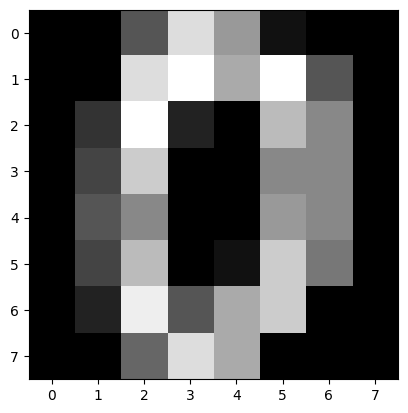

In [420]:
plt.imshow(X[0].reshape(8,8), cmap='gray')
plt.show()

In [4]:
lib = ctypes.CDLL('./main.so')

train_dataset = Dataset(samples=X_train, targets=y_train_one_hot)
val_dataset = Dataset(samples=X_val, targets=y_val)

layers = [
    Linear(8*8,1000, activation=Sigmoid(), dropout=0.2),
    Linear(1000,2, activation=Softmax()),
]

model = Model(layers=layers, loss=CrossEntropy(), regression=False, max_change=0.0000000000001)
losses = model.fit(dataset=train_dataset, n_epoch=1, learning_rate=0.1, verbose=True, num_cpu=NUM_CPU)

predictions = model.predict(X_val, num_cpu=NUM_CPU)

accuracy_score(y_true=y_val, y_pred=predictions) * 100

56.94444444444444

In [ ]:
plt.plot(losses)
plt.show()

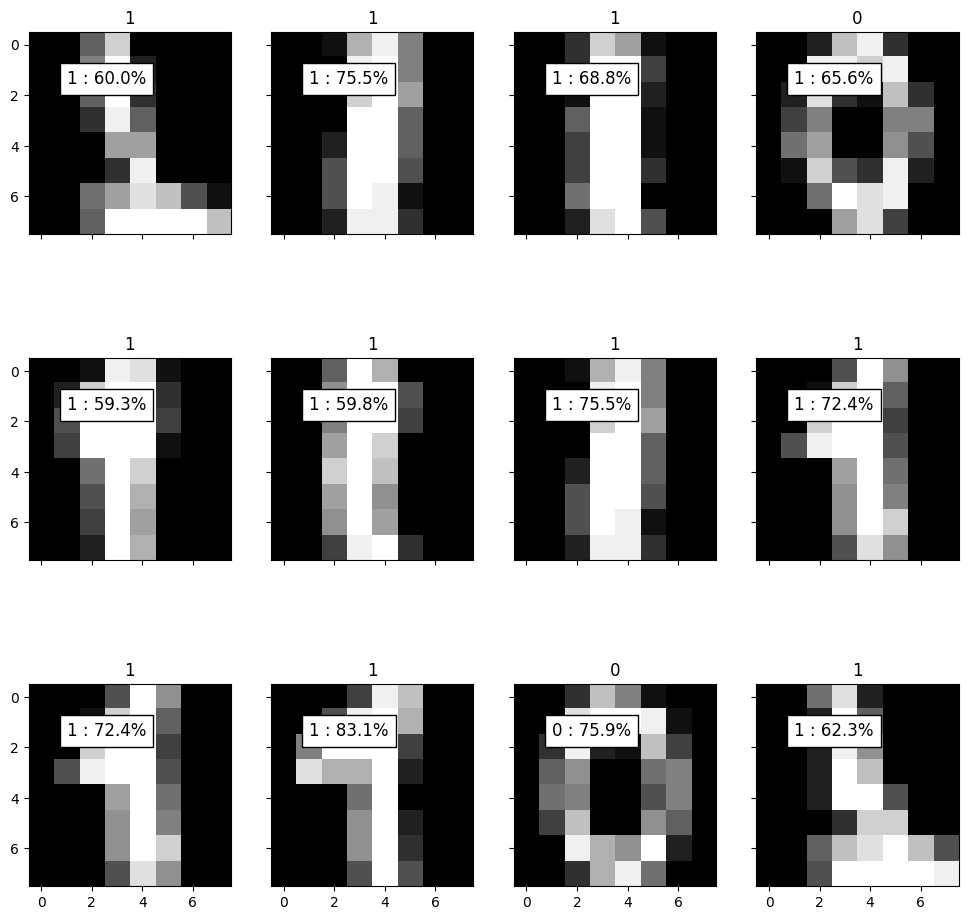

In [ ]:
def imshow(inp, title=None, plt_ax=plt):
    """Imshow для тензоров"""
    plt_ax.imshow(inp.reshape(8,8), cmap='gray')

    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)


fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(12, 12), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, len(val_dataset)))
    im_val, label = val_dataset[random_characters]

    imshow(im_val[0], title=label, plt_ax=fig_x)

    predicted_label = model.predict_one(im_val)

    predicted_proba = model.predict_one(im_val, predict_proba=True)
    predicted_proba = np.max(predicted_proba)
    predicted_proba *= 100

    predicted_text = "{} : {:.1f}%".format(predicted_label, predicted_proba)

    fig_x.text(1, 1, predicted_text, horizontalalignment='left', verticalalignment='top', fontsize=12, color='black', bbox=dict(facecolor='white', edgecolor='black', pad=5))

## Apply Conv2d

In [13]:
X_reshaped = []
for sample in X:
    sample = torch.tensor(sample.reshape(8,8), dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    X_reshaped.append(sample)


X_train, X_val, y_train_one_hot, y_val_one_hot = train_test_split(X_reshaped, y_one_hot, train_size=0.8)

y_val = np.zeros(len(y_val_one_hot), dtype=int)
for i in range(len(y_val_one_hot)):
    for j in range(len(y_val_one_hot[i])):
        if y_val_one_hot[i][j] == 1:
            y_val[i] = j
            break

In [14]:
X_train[0]

tensor([[[[ 0.,  0.,  1., 15., 13.,  0.,  0.,  0.],
          [ 0.,  0.,  1., 16., 16.,  5.,  0.,  0.],
          [ 0.,  0.,  7., 16., 16.,  0.,  0.,  0.],
          [ 0.,  0., 13., 16., 13.,  0.,  0.,  0.],
          [ 0.,  7., 16., 16., 13.,  0.,  0.,  0.],
          [ 0.,  1., 11., 16., 13.,  0.,  0.,  0.],
          [ 0.,  0.,  2., 16., 16.,  0.,  0.,  0.],
          [ 0.,  0.,  1., 14., 16.,  3.,  0.,  0.]]]])

In [ ]:
lib = ctypes.CDLL('./main.so')

train_dataset = Dataset(samples=X_train, targets=y_train_one_hot)
val_dataset = Dataset(samples=X_val, targets=y_val)

layers = [
    Conv2d(1, 64, kernel_size=1, stride=1, activation=Sigmoid(), batch_norm=64),
    Conv2d(64, 128, kernel_size=1, stride=1, activation=Sigmoid(), batch_norm=128),
    Conv2d(128, 64, kernel_size=1, stride=1, activation=Sigmoid(), batch_norm=64),
    Conv2d(64, 1, kernel_size=1, stride=1, activation=Sigmoid(), batch_norm=1),
    Linear(8*8,64, activation=Sigmoid(), dropout=0.2),
    Linear(64,2, activation=Softmax()),
]


model = Model(layers=layers, loss=CrossEntropy(), regression=False, max_change=0.0000000000001)
losses = model.fit(dataset=train_dataset, n_epoch=1, learning_rate=0.1, verbose=True, num_cpu=NUM_CPU)
predictions = model.predict(X_val)

accuracy_score(y_true=y_val, y_pred=predictions) * 100

[11-08-2025 14:21:59] - INFO - Preparing the dataset.
[11-08-2025 14:21:59] - INFO - Dataset preparation completed.
[11-08-2025 14:21:59] - INFO - Training has started.
[11-08-2025 14:21:59] - INFO - Forward step.
[11-08-2025 14:21:59] - INFO - Backward step.
[11-08-2025 14:21:59] - INFO - Update weights and biases step.
[11-08-2025 14:21:59] - INFO - Clearing memory.
[11-08-2025 14:21:59] - INFO - Epoch 1 / 1. Loss: -1.271052
[11-08-2025 14:21:59] - INFO - Training is over.


/var/folders/07/5w1xtr897qz76752j_ppn7nw0000gn/T/ipykernel_94635/1697135836.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = torch.tensor(sample, dtype=torch.float32)


94.44444444444444

/var/folders/07/5w1xtr897qz76752j_ppn7nw0000gn/T/ipykernel_94635/1697135836.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = torch.tensor(sample, dtype=torch.float32)


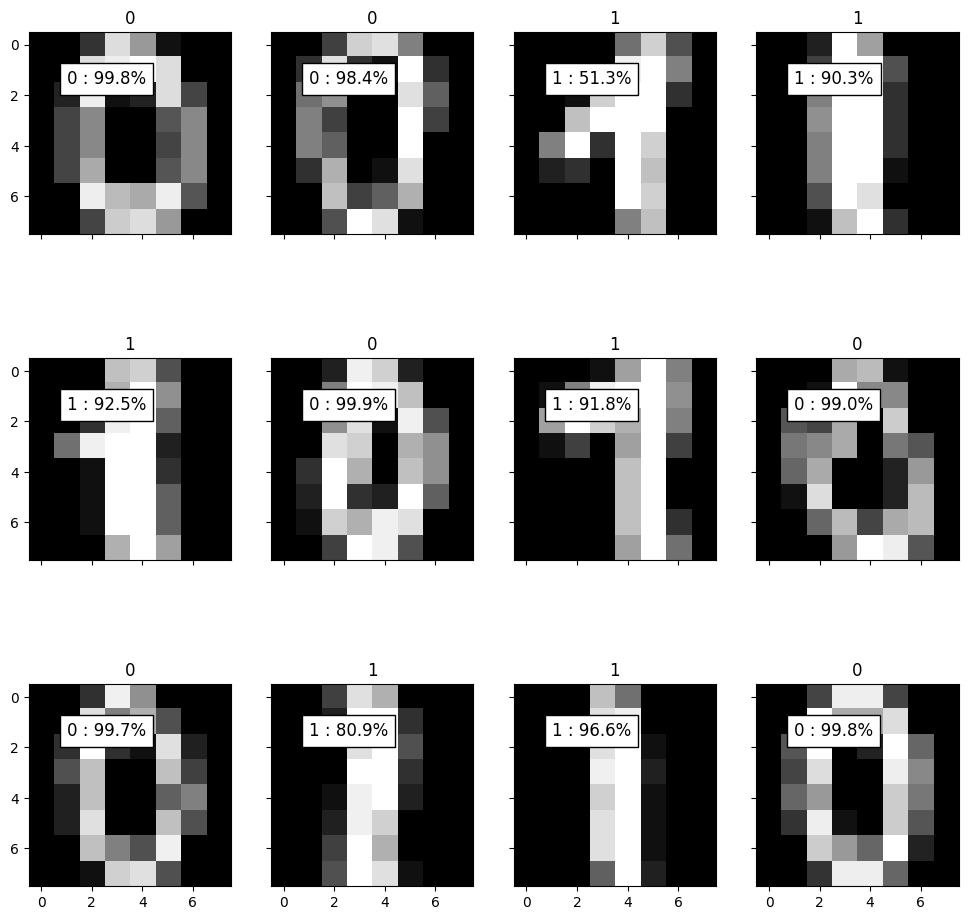

In [ ]:
def imshow(inp, title=None, plt_ax=plt):
    """Imshow для тензоров"""
    plt_ax.imshow(inp.reshape(8,8), cmap='gray')

    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)


fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(12, 12), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, len(val_dataset)))
    im_val, label = val_dataset[random_characters]

    imshow(im_val[0], title=label, plt_ax=fig_x)

    predicted_label = model.predict_one(im_val)

    predicted_proba = model.predict_one(im_val, predict_proba=True)
    predicted_proba = np.max(predicted_proba)
    predicted_proba *= 100

    predicted_text = "{} : {:.1f}%".format(predicted_label, predicted_proba)

    fig_x.text(1, 1, predicted_text, horizontalalignment='left', verticalalignment='top', fontsize=12, color='black', bbox=dict(facecolor='white', edgecolor='black', pad=5))

# Torchvision MNIST

In [14]:
import torchvision
from torchvision import transforms

trainset = torchvision.datasets.MNIST("./", transform=transforms.ToTensor(), train=False, download=True)

In [15]:
X, y = [], []

for item in trainset:
    X.append(item[0])
    y.append(item[1])

In [71]:
len(X)

10000

In [65]:
X[0].shape

torch.Size([1, 28, 28])

In [66]:
y[0]

7

In [16]:
for i in range(len(X)):
    X[i] = torch.flatten(X[i])

In [59]:
for i in range(len(X)):
    X[i] /= 255

In [29]:
X[0].shape

torch.Size([784])

In [17]:
X_reshaped = []
for i in range(len(X)):
    x = [X[i]]
    X_reshaped.append(x)

y_one_hot = np.zeros(len(y))
y_one_hot = list(y_one_hot)
for i in range(len(y)):
    if y[i] == 0:
        y_one_hot[i] = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    elif y[i] == 1:
        y_one_hot[i] = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
    elif y[i] == 2:
        y_one_hot[i] = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
    elif y[i] == 3:
        y_one_hot[i] = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
    elif y[i] == 4:
        y_one_hot[i] = np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
    elif y[i] == 5:
        y_one_hot[i] = np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
    elif y[i] == 6:
        y_one_hot[i] = np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
    elif y[i] == 7:
        y_one_hot[i] = np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
    elif y[i] == 8:
        y_one_hot[i] = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])
    elif y[i] == 9:
        y_one_hot[i] = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

y_one_hot = np.array(y_one_hot)

X_train, X_val, y_train_one_hot, y_val_one_hot = train_test_split(X_reshaped, y_one_hot, train_size=0.8)

y_val = np.zeros(len(y_val_one_hot), dtype=int)

for i in range(len(y_val_one_hot)):
    for j in range(len(y_val_one_hot[i])):
        if y_val_one_hot[i][j] == 1:
            y_val[i] = j
            break

In [ ]:
lib = ctypes.CDLL('./main.so')

train_dataset = Dataset(samples=X_train, targets=y_train_one_hot)
val_dataset = Dataset(samples=X_val, targets=y_val)

layers = [
    Linear(28*28,1000, activation=Sigmoid(), dropout=0.2),
    Linear(1000,10, activation=Softmax()),
]

model = Model(layers=layers, loss=CrossEntropy(), regression=False, max_change=0.0000001)

t_1 = time.time()
losses = model.fit(dataset=train_dataset, n_epoch=1, learning_rate=0.1, verbose=True, num_cpu=NUM_CPU)
t_2 = time.time()
print(t_2 - t_1)

predictions = model.predict(X_val, num_cpu=NUM_CPU)

accuracy_score(y_true=y_val, y_pred=predictions) * 100

[04-08-2025 13:29:56] - INFO - Preparing the dataset.
[04-08-2025 13:29:56] - INFO - Dataset preparation completed.
[04-08-2025 13:29:56] - INFO - Training has started.
[04-08-2025 13:29:56] - INFO - Forward step
[04-08-2025 13:29:56] - INFO - Backward step
[04-08-2025 13:30:07] - INFO - Update weights and biases step
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
19

13.0

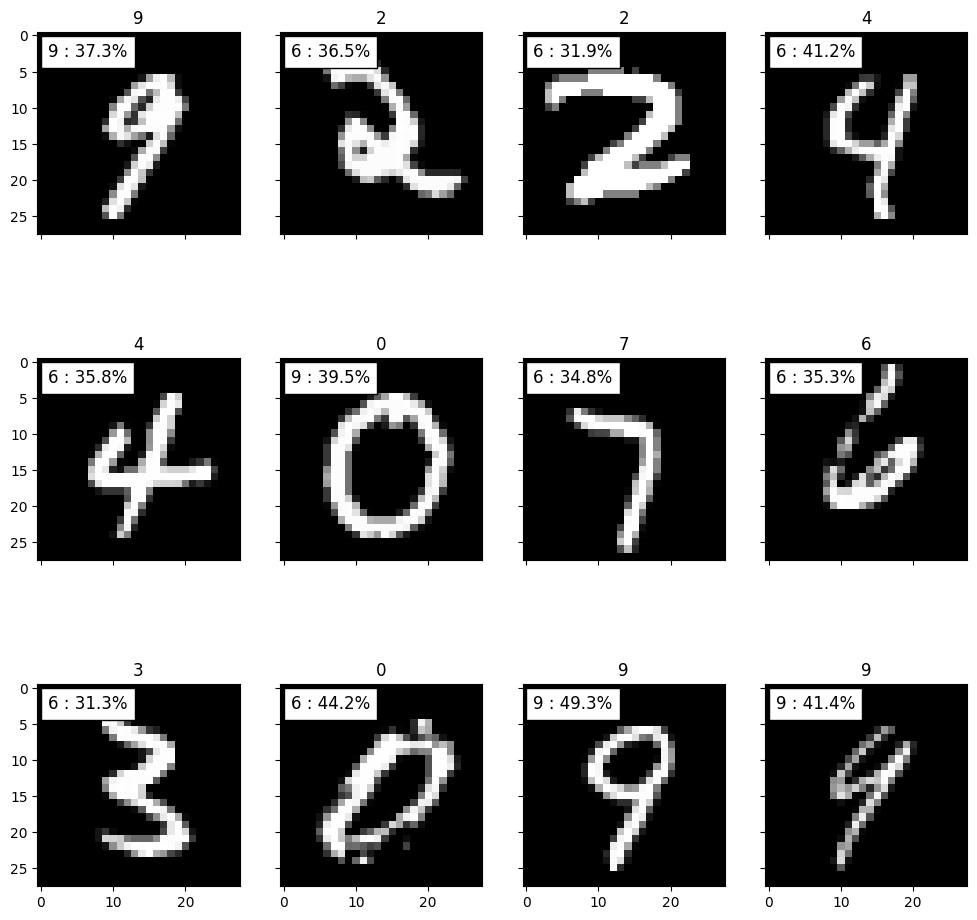

In [ ]:
def imshow(inp, title=None, plt_ax=plt):
    """Imshow для тензоров"""
    plt_ax.imshow(inp.reshape(28,28), cmap='gray')

    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)


fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(12, 12), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, len(val_dataset)))
    im_val, label = val_dataset[random_characters]

    imshow(im_val[0], title=label, plt_ax=fig_x)

    predicted_label = model.predict_one(im_val)

    predicted_proba = model.predict_one(im_val, predict_proba=True)
    predicted_proba = np.max(predicted_proba)
    predicted_proba *= 100

    predicted_text = "{} : {:.1f}%".format(predicted_label, predicted_proba)

    fig_x.text(1, 1, predicted_text, horizontalalignment='left', verticalalignment='top', fontsize=12, color='black', bbox=dict(facecolor='white', edgecolor='black', pad=5))

## Apply Conv2d

In [18]:
X_reshaped = []
for sample in X:
    sample = torch.tensor(sample.reshape(28,28), dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    X_reshaped.append(sample)

/tmp/ipykernel_18242/3772461225.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = torch.tensor(sample.reshape(28,28), dtype=torch.float32).unsqueeze(0).unsqueeze(0)


In [19]:
X_train, X_val, y_train_one_hot, y_val_one_hot = train_test_split(X_reshaped, y_one_hot, train_size=0.8)

y_val = np.zeros(len(y_val_one_hot), dtype=int)
for i in range(len(y_val_one_hot)):
    for j in range(len(y_val_one_hot[i])):
        if y_val_one_hot[i][j] == 1:
            y_val[i] = j
            break

In [20]:
lib = ctypes.CDLL('./main.so')

train_dataset = Dataset(samples=X_train, targets=y_train_one_hot)
val_dataset = Dataset(samples=X_val, targets=y_val)

layers = [
    Conv2d(1, 128, kernel_size=3, stride=1, padding=1, activation=Sigmoid(), batch_norm=128),
    MaxPool2d(kernel_size=2, stride=2),
    Conv2d(128, 256, kernel_size=3, stride=1, padding=1, activation=Sigmoid(), batch_norm=256),
    MaxPool2d(kernel_size=2, stride=2),
    Conv2d(256, 128, kernel_size=3, stride=1, padding=1, activation=Sigmoid(), batch_norm=128),
    MaxPool2d(kernel_size=2, stride=2),
    Linear(1152,128, activation=Sigmoid()),
    Linear(128,10, activation=Softmax()),
]

model = Model(layers=layers, loss=CrossEntropy(), regression=False, max_change=0.000001)

t_1 = time.time()
model.fit(dataset=train_dataset, n_epoch=1, learning_rate=0.1, verbose=True, gpu=0, num_cpu=1)
t_2 = time.time()
print(t_2 - t_1)


predictions = model.predict(X_val)

accuracy_score(y_true=y_val, y_pred=predictions) * 100

[13-08-2025 17:54:29] - INFO - Preparing the dataset.
[13-08-2025 17:54:29] - INFO - Dataset preparation completed.
[13-08-2025 17:54:29] - INFO - Training has started.
[13-08-2025 17:54:29] - INFO - Apply Conv2d.
[13-08-2025 17:54:40] - INFO - Forward step.
[13-08-2025 17:54:41] - INFO - Backward step.
[13-08-2025 17:54:43] - INFO - Update weights and biases step.
[13-08-2025 17:54:45] - INFO - Clearing memory.
[13-08-2025 17:54:45] - INFO - Epoch 1 / 1. Loss: -310.849152
[13-08-2025 17:54:45] - INFO - Training is over.
15.830792665481567


/tmp/ipykernel_18242/599535427.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = torch.tensor(sample, dtype=torch.float32)


9.75

[1.1468371e-02 1.3359802e-05 3.3790134e-02 2.7041193e-04 4.3126587e-03
 8.9856881e-01 4.3126587e-03 1.2511197e-02 4.3126587e-03 3.0439859e-02]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1.6594823e-02 8.9576315e-06 1.6688210e-01 4.5078792e-04 6.1006271e-03
 7.6281351e-01 6.1006271e-03 1.6660709e-02 6.1006271e-03 1.8287286e-02]
[1.0689905e-02 8.1457656e-06 9.9703655e-02 7.4443599e-04 7.8242086e-03
 7.4853659e-01 7.8242086e-03 2.6234802e-02 7.8242086e-03 9.0609781e-02]
[1.3457389e-02 1.7450140e-05 6.8675712e-02 1.0359730e-03 7.7433339e-03
 7.8986126e-01 7.7433339e-03 2.0202173e-02 7.7433339e-03 8.3520047e-02]
[2.0718094e-02 2.9929419e-05 1.0855232e-01 9.1721688e-04 7.3915189e-03
 7.5960088e-01 7.3915189e-03 3.6815692e-02 7.3915189e-03 5.1191352e-02]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1.0929371e-02 8.0537448e-06 3.5514429e-02 7.8564230e-04 5.8813239e-03
 8.2384712e-01 5.8813239e-03 2.5013436e-02 5.8813239e-03 8.6257920e-02]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0

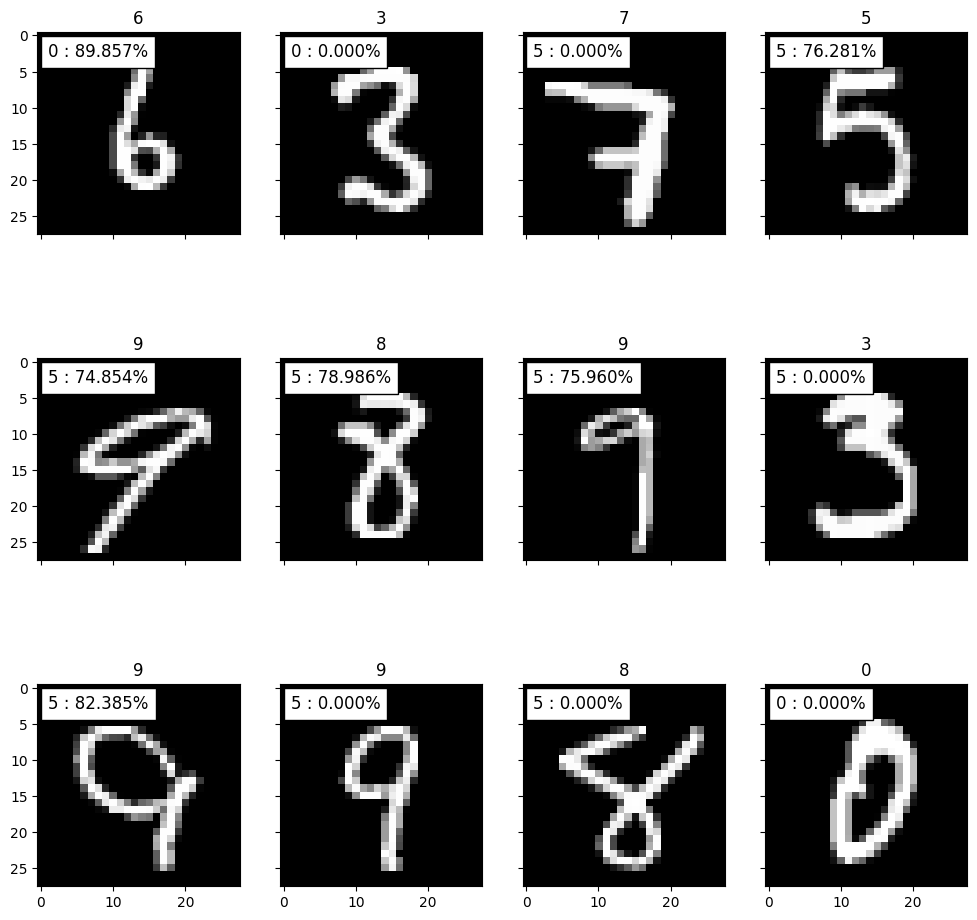

In [48]:
def imshow(inp, title=None, plt_ax=plt):
    """Imshow для тензоров"""
    plt_ax.imshow(inp.reshape(28,28), cmap='gray')

    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)


fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(12, 12), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, len(val_dataset)))
    im_val, label = val_dataset[random_characters]

    imshow(im_val[0], title=label, plt_ax=fig_x)

    predicted_label = model.predict_one(im_val)

    predicted_proba = model.predict_one(im_val, predict_proba=True)
    print(predicted_proba)
    predicted_proba = np.max(predicted_proba)
    predicted_proba *= 100

    predicted_text = "{} : {:.3f}%".format(predicted_label, predicted_proba)

    fig_x.text(1, 1, predicted_text, horizontalalignment='left', verticalalignment='top', fontsize=12, color='black', bbox=dict(facecolor='white', edgecolor='black', pad=5))